# 0. NOTES


FULL CODE EXAMPLE FOR A SIMPLE CHATBOT USING BOTH:
1) An Artificial Neural Network (ANN)
2) A Transformer-Based Model

This script demonstrates:
  - Environment setup (imports)
  - Data loading and preprocessing
   - ANN model training and inference
   - Transformer model training and inference
   - Performance comparison

# NOTE:
   - The code below is a unified example; in practice, you might split it into multiple files (e.g., data_preprocessing.py, models.py, train.py).
   - Adjust file paths, hyperparameters, and dataset loading as necessary.
   - Ensure the product_reviews.csv file has columns named "review" and "label".
   - Installing dependencies (outside of Python):
      pip install torch torchvision torchaudio
      pip install numpy pandas scikit-learn

Please note that for large or complex datasets, a more efficient approach (especially for the Transformer part) might be needed. 

# 1. ENVIRONMENT SETUP & IMPORTS

In [1]:
import torch

# --- Intel Extension for PyTorch (Optional but used for Transformer) ---
try:
    import intel_extension_for_pytorch as ipex
    print("Intel Extension for PyTorch (IPEX) found.")
    HAS_IPEX = True
except ImportError:
    print("Intel Extension for PyTorch (IPEX) not found. Transformer will run without IPEX optimization.")
    HAS_IPEX = False

# --- Device Selection ---
if HAS_IPEX and hasattr(torch, "xpu") and torch.xpu.is_available():
    device = torch.device("xpu")
    print("Using XPU device.")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device.")


Intel Extension for PyTorch (IPEX) found.
Using XPU device.


IMPORTING ALL THE OTHER IMPORTS NECESSARY

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re # Import re for preprocessing
import time

# Download NLTK data
try:
    stopwords.words('english')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK data (stopwords and punkt)...")
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    print("NLTK data downloaded.")

# 2. DATA LOADING & PREPROCESSING

In [25]:
# Hyperparameters
CSV_PATH = r"amazon_cells_labelled_LARGE_25K.txt" # Adjust the path to your csv file as needed.
MAX_FEATURES = 50000 # TF-IDF feature limit
BATCH_SIZE = 64 # Adjusted batch size for potentially larger memory footprint
ANN_EPOCHS = 5 # Number of epochs for ANN
TRANSFORMER_EPOCHS = 5 # Number of epochs for Transformer
ANN_LR = 0.0005 # Learning rate for ANN
TRANSFORMER_LR = 0.0005 # Learning rate for Transformer
WEIGHT_DECAY = 0.01 # Weight decay for AdamW

In [ ]:
# Data Preprocessing Function
def preprocess_pandas(data, columns):
    df = pd.DataFrame(columns=columns)
    data['review'] = data['review'].str.lower()
    data['review'] = data['review'].replace(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)  # remove emails
    data['review'] = data['review'].replace(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)  # remove IP address
    data['review'] = data['review'].str.replace(r'[^\w\s]', '', regex=True)  # remove special characters
    data['review'] = data['review'].replace(r'\d', '', regex=True)  # remove numbers

    stop_words = set(stopwords.words('english'))

    processed_rows = []
    for index, row in data.iterrows():
        if pd.isna(row['review']): # Skip if review became NaN after processing
             continue
        word_tokens = word_tokenize(row['review'])
        filtered_sent = [w for w in word_tokens if not w in stop_words and w.strip()] # Ensure token is not empty
        processed_rows.append({
            "index": row['index'],
            "label": row['label'],
            "review": " ".join(filtered_sent)
        })

    df = pd.DataFrame(processed_rows) # More efficient way to build DataFrame
    # Ensure label is integer type
    df['label'] = df['label'].astype(int)
    return df


# Dataset Class
class ReviewsDataset(Dataset):
    """
    Torch Dataset that takes in lists (or Series) of texts and labels
    along with the vectorizer to transform texts.
    Yields dense vectors suitable for ANN/Transformer input.
    """
    def __init__(self, texts, labels, vectorizer):
        # Reset index to ensure consistent indexing
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)  # Ensure labels have matching indices
        self.vectorizer = vectorizer
        # Ensure labels are numeric
        self.labels = pd.to_numeric(self.labels, errors='coerce').fillna(0).astype(int)


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if idx >= len(self.texts):
             raise IndexError("Index out of bounds")
        text = self.texts[idx]
        label = self.labels[idx]

        # Check for NaN or unexpected types before vectorizing
        if pd.isna(text) or not isinstance(text, str):
             text = "" # Replace NaN/invalid with empty string

        # Transform text to a sparse vector and then to a dense numpy array
        # Note: .toarray() can be memory intensive for large vocab/batch size
        try:
            text_vector = self.vectorizer.transform([text]).toarray().flatten() # Flatten to 1D array
        except Exception as e:
            print(f"Error vectorizing text at index {idx}: '{text}'. Error: {e}")
            # Return a zero vector of the expected shape if error occurs
            # Get expected shape from a valid transformation if possible
            try:
                expected_shape = self.vectorizer.transform(["a"]).shape[1]
            except:
                expected_shape = 50000 # Fallback to max_features if needed
            text_vector = np.zeros(expected_shape, dtype=np.float32)


        # Ensure label is a scalar tensor
        label_tensor = torch.FloatTensor([label]) # Label should be single value

        return torch.FloatTensor(text_vector), label_tensor
    

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    
    # --- Load and Preprocess Data ---
    print("Loading data...")
    try:
        data = pd.read_csv(CSV_PATH, delimiter='\t', header=None, names=['review', 'label'], on_bad_lines='skip')
        data['index'] = data.index
        print(f"Loaded {len(data)} rows.")
    except FileNotFoundError:
        print(f"Error: File not found at {CSV_PATH}")
        exit()
    except Exception as e:
        print(f"Error loading data: {e}")
        exit()

    print("Preprocessing data...")
    columns = ['index', 'label', 'review']
    processed_data = preprocess_pandas(data, columns)
    print(f"Preprocessing complete. {len(processed_data)} rows remaining.\n")

    # --- Split Data ---
    print("Splitting data...")
    train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42, stratify=processed_data['label'])
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label']) # 0.2 of 0.8 = 0.16

    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    print(f"Test samples: {len(test_data)}\n")

    # --- Vectorization ---
    print("Vectorizing text data using TF-IDF...")
    vectorizer = TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_features=MAX_FEATURES,
        max_df=0.7, # Ignore terms in > 70% of docs
        min_df=3,   # Ignore terms in < 3 docs
        use_idf=True,
        norm='l2'
    )
    # Fit on training data only
    vectorizer.fit(train_data['review'])
    input_dim = len(vectorizer.vocabulary_) # Get actual input dimension after fitting
    print(f"Actual vocabulary size (input_dim): {input_dim}\n")

    # --- Create Datasets and DataLoaders ---
    print("Creating Datasets and DataLoaders...")
    train_dataset = ReviewsDataset(train_data['review'], train_data['label'], vectorizer)
    val_dataset = ReviewsDataset(val_data['review'], val_data['label'], vectorizer)
    test_dataset = ReviewsDataset(test_data['review'], test_data['label'], vectorizer)

    # Use pin_memory=True if using GPU (CUDA or XPU) for faster data transfer
    pin_memory_flag = (device.type == 'cuda' or device.type == 'xpu')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pin_memory_flag) # num_workers=0 for compatibility
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin_memory_flag)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin_memory_flag)
    print(f"Dataloaders created with batch size {BATCH_SIZE}")

Loading data...
Loaded 25000 rows.
Preprocessing data...
Preprocessing complete. 25000 rows remaining.

Splitting data...
Training samples: 16000
Validation samples: 4000
Test samples: 5000

Vectorizing text data using TF-IDF...
Actual vocabulary size (input_dim): 10750

Creating Datasets and DataLoaders...
Dataloaders created with batch size 64


# 3. TASK 1.1: ANN AND TRANSFORMER MODEL DEFINITION & TRAINING

In [ ]:
class SimpleANN(nn.Module):
    """
    A simple feed-forward ANN for binary classification (25k dataset version).
    Includes dropout for regularization.
    """
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, dropout_prob=0.1): # Increased hidden_dim, added dropout
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob) # Added dropout
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2) # Added another layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim) # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        # Output x shape: (batch_size, 1)
        return x
    

class TransformerClassifier(nn.Module):
    """
    Transformer-based model for binary classification.
    Uses TransformerEncoder on the full TF-IDF vector as a single token.
    Includes input dimension adjustment and padding/truncation.
    """
    def __init__(self, input_dim, nhead=4, num_layers=2, d_model_override=512, hidden_dim=256, dropout_prob=0.1):
        super(TransformerClassifier, self).__init__()

        # Use a fixed d_model, potentially smaller than input_dim
        # This requires an input projection layer.
        self.d_model = d_model_override # 512 - must be divisible by nhead
        if self.d_model % nhead != 0:
             raise ValueError(f"d_model ({self.d_model}) must be divisible by nhead ({nhead})")
        print(f"Using fixed d_model = {self.d_model}")

        # --- Input Projection Layer ---
        self.input_projection = nn.Linear(input_dim, self.d_model)
        # -----------------------------

        self.encoder_layer = TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=nhead,
            dim_feedforward=self.d_model * 2, # Common practice: 2x or 4x d_model
            dropout=dropout_prob, # Dropout within the transformer layer
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc1 = nn.Linear(self.d_model, hidden_dim) # Input is d_model
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob) # Dropout after activation
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, src):
        # Input src shape: (batch_size, original_input_dim) from DataLoader
        # Add sequence dimension: (batch_size, 1, original_input_dim)
        if src.dim() == 2:
            src = src.unsqueeze(1)

        # Project input dimension to d_model
        # Input: (batch_size, 1, original_input_dim) -> Output: (batch_size, 1, d_model)
        projected_src = self.input_projection(src)

        # Pass through transformer encoder
        # Input: (batch_size, 1, d_model), Output: (batch_size, 1, d_model)
        encoded = self.transformer_encoder(projected_src)

        # Take the output corresponding to the single "token"
        encoded_output = encoded[:, 0, :]  # Shape: (batch_size, d_model)

        # Classification head
        x = self.fc1(encoded_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        probs = self.sigmoid(x) # Shape: (batch_size, 1)
        return probs


# 4.1 FUNCTIONS FOR MODEL TRAINING AND PLOTTING OF TRAINING RESULTS

In [23]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5, model_name="model", scheduler=None):
    """
    Generic training loop for both ANN and Transformer models using DataLoaders.
    Includes accuracy calculation, validation, and optional LR scheduling.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"\n--- Training {model_name} ---")
    model.to(device) # Ensure model is on the correct device

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # Shape: (batch_size, 1)
            loss = criterion(outputs, labels) # labels shape: (batch_size, 1)

            # Check for NaN loss
            if torch.isnan(loss):
                print(f"NaN loss detected at batch {i}! Skipping batch.")
                continue # Skip backward pass and optimizer step for this batch

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Store predictions and true labels for accuracy calculation
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.detach().cpu().numpy())
            train_true.extend(labels.detach().cpu().numpy())

        avg_train_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        train_accuracy = accuracy_score(np.array(train_true).flatten(), np.array(train_preds).flatten()) if len(train_true) > 0 else 0.0

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_outputs = model(inputs)
                val_loss += criterion(val_outputs, labels).item()

                # Store predictions and true labels
                preds = (val_outputs > 0.5).float()
                val_preds.extend(preds.detach().cpu().numpy())
                val_true.extend(labels.detach().cpu().numpy())

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0.0
        val_accuracy = accuracy_score(np.array(val_true).flatten(), np.array(val_preds).flatten()) if len(val_true) > 0 else 0.0

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        epoch_duration = time.time() - epoch_start_time

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Duration: {epoch_duration:.2f}s")

        # Learning rate scheduler step
        if scheduler:
             if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                 scheduler.step(avg_val_loss) # ReduceLROnPlateau needs the metric
             else:
                 scheduler.step() 

    print(f"--- Finished Training {model_name} ---")
    return train_losses, val_losses, train_accuracies, val_accuracies


# Plotting Function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs, model_name):
    """
    Plots the training and validation loss and accuracy curves.
    """
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-o', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'b-o', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, 'r-o', label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'{model_name} Training Metrics')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()



def chatbot_response(model, vectorizer, user_input, device, model_name="Model"):
    """
    Generic chatbot response function for both models.
    """
    model.eval() # Put model in evaluation mode
    model.to(device)

    # Preprocess user input similarly to training data
    processed_input = user_input.lower()
    processed_input = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', processed_input)
    processed_input = re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', processed_input)
    processed_input = re.sub(r'[^\w\s]', '', processed_input)
    processed_input = re.sub(r'\d', '', processed_input)
    word_tokens = word_tokenize(processed_input)
    stop_words = set(stopwords.words('english'))
    filtered_sent = [w for w in word_tokens if not w in stop_words and w.strip()]
    final_input = " ".join(filtered_sent)

    # Vectorize using the same fitted vectorizer
    try:
        user_vec = vectorizer.transform([final_input]).toarray().flatten()
    except Exception as e:
        print(f"Error vectorizing user input: {e}")
        return "Sorry, I couldn't process that input."

    user_tensor = torch.FloatTensor(user_vec).unsqueeze(0).to(device) # Add batch dim and move to device

    with torch.no_grad():
        output = model(user_tensor) # Get model output

    sentiment_positive = (output.item() > 0.5)
    sentiment = "Positive" if sentiment_positive else "Negative"
    print(f"[{model_name} Prediction]: Score={output.item():.4f} -> {sentiment}")
    return f"It sounds {sentiment.lower()}!"

# 4.2 MODEL TRAINING AND EVALUATION


Initializing SimpleANN model...

--- Training SimpleANN ---
Epoch [1/5], Train Loss: 0.4590, Train Acc: 0.7707, Val Loss: 0.3335, Val Acc: 0.8580, Duration: 8.82s
Epoch [2/5], Train Loss: 0.2206, Train Acc: 0.9136, Val Loss: 0.3578, Val Acc: 0.8510, Duration: 8.55s
Epoch [3/5], Train Loss: 0.1430, Train Acc: 0.9506, Val Loss: 0.4251, Val Acc: 0.8420, Duration: 8.54s
Epoch [4/5], Train Loss: 0.0929, Train Acc: 0.9699, Val Loss: 0.5221, Val Acc: 0.8293, Duration: 8.72s
Epoch [5/5], Train Loss: 0.0472, Train Acc: 0.9886, Val Loss: 0.5410, Val Acc: 0.8330, Duration: 8.61s
--- Finished Training SimpleANN ---


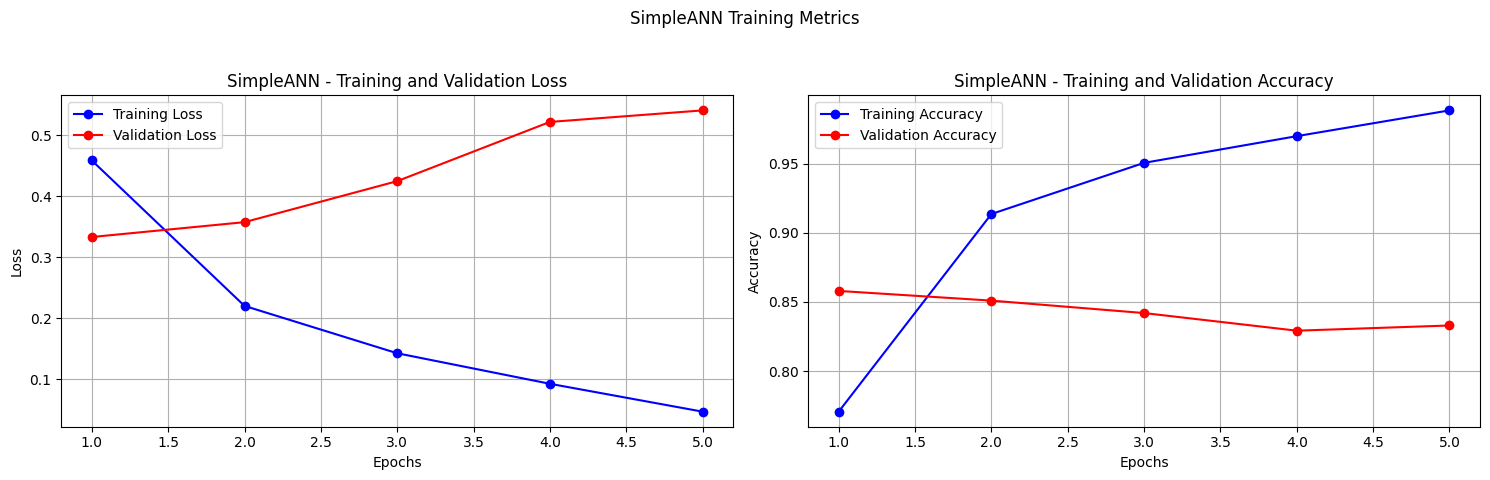


Initializing TransformerClassifier model...
Using fixed d_model = 256
Applying IPEX optimization to Transformer model...
IPEX optimization applied successfully.

--- Training TransformerClassifier ---
Epoch [1/5], Train Loss: 0.3938, Train Acc: 0.8231, Val Loss: 0.3645, Val Acc: 0.8427, Duration: 12.38s
Epoch [2/5], Train Loss: 0.1918, Train Acc: 0.9228, Val Loss: 0.4032, Val Acc: 0.8397, Duration: 12.64s
Epoch [3/5], Train Loss: 0.1285, Train Acc: 0.9453, Val Loss: 0.5804, Val Acc: 0.8347, Duration: 12.49s
Epoch [4/5], Train Loss: 0.1005, Train Acc: 0.9564, Val Loss: 0.5909, Val Acc: 0.8175, Duration: 12.83s
Epoch [5/5], Train Loss: 0.0550, Train Acc: 0.9756, Val Loss: 0.7560, Val Acc: 0.8285, Duration: 12.47s
--- Finished Training TransformerClassifier ---


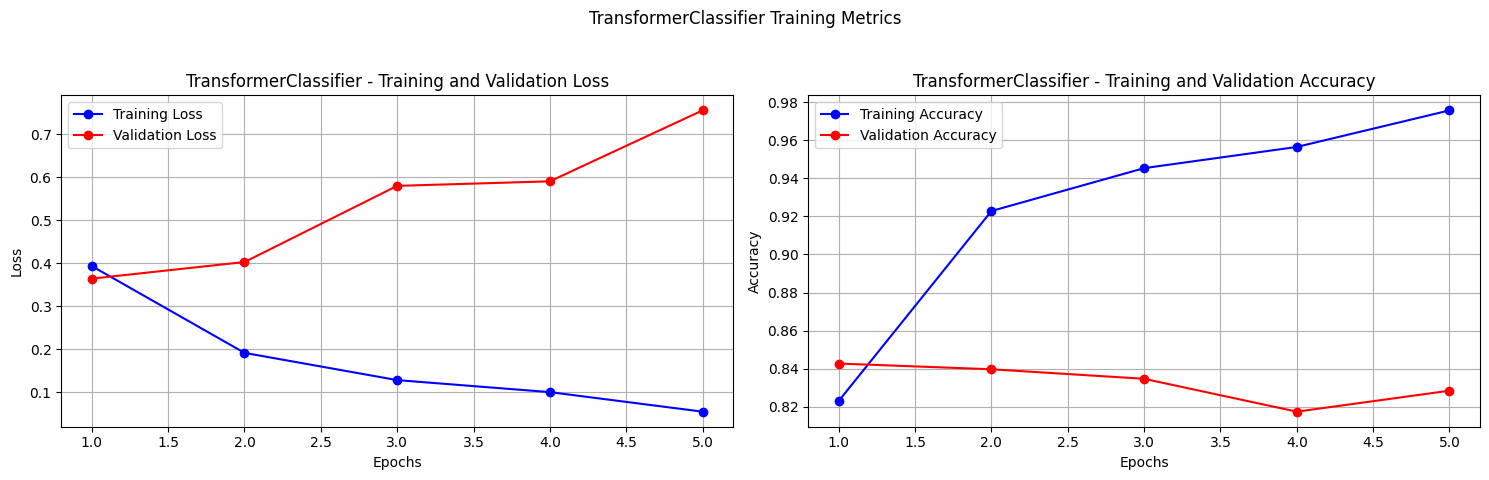

In [ ]:
# Simple ANN Model Training
print("\nInitializing SimpleANN model...")
model_ann = SimpleANN(input_dim=input_dim).to(device) # Pass actual input_dim
criterion_ann = nn.BCELoss()
optimizer_ann = optim.AdamW(model_ann.parameters(), lr=ANN_LR, weight_decay=WEIGHT_DECAY)
model_ann, optimizer_ann = ipex.optimize(model_ann, optimizer=optimizer_ann) # REMOVED due to error

# Learning Rate Scheduler for ANN
scheduler_ann = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ann, 'min', factor=0.1, patience=2)

ann_metrics = train_model(
    model_ann, criterion_ann, optimizer_ann,
    train_loader, val_loader, device, epochs=ANN_EPOCHS,
    model_name="SimpleANN", scheduler=scheduler_ann
)
plot_metrics(*ann_metrics, ANN_EPOCHS, "SimpleANN")


# Transformer Model Training
print("\nInitializing TransformerClassifier model...")
    # Ensure nhead is compatible with d_model if d_model is derived from input_dim
    # Using fixed d_model and input projection is generally more robust
model_transformer = TransformerClassifier(
        input_dim=input_dim, # Pass actual input_dim
        nhead=4,             
        num_layers=2,        
        d_model_override=256,# Must be divisible by nhead (256 % 4 == 0)
        hidden_dim=128,      # Classifier hidden dim
        dropout_prob=0.1     # Dropout rate
        ).to(device)

criterion_transformer = nn.BCELoss()
optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=TRANSFORMER_LR, weight_decay=WEIGHT_DECAY)

# Apply IPEX optimization ONLY if IPEX is available and desired for Transformer
if HAS_IPEX and (device.type == 'xpu' or device.type == 'cpu'): # IPEX optimize usually targets CPU/XPU
    try:
            model_transformer, optimizer_transformer = ipex.optimize(model_transformer, optimizer=optimizer_transformer)
            print("IPEX optimization applied successfully.")
    except Exception as e:
            print(f"IPEX optimization failed for Transformer: {e}. Continuing without IPEX.")
else:
    print("Skipping IPEX optimization for Transformer (IPEX not available/enabled or device is not CPU/XPU).")


# Learning Rate Scheduler for Transformer
scheduler_transformer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_transformer, 'min', factor=0.1, patience=2)

transformer_metrics = train_model(
    model_transformer, criterion_transformer, optimizer_transformer,
    train_loader, val_loader, device, epochs=TRANSFORMER_EPOCHS,
    model_name="TransformerClassifier", scheduler=scheduler_transformer
)
plot_metrics(*transformer_metrics, TRANSFORMER_EPOCHS, "TransformerClassifier")   

# 5 MODEL TESTING AND EVALUATION

In [28]:
# Chatbot Interaction Examples
print("\n--- Chatbot Testing ---")
test_inputs = [
    "This product is absolutely fantastic, works perfectly!",
    "Terrible quality, broke after just one day.",
    "It's okay, does the job but nothing special.",
    "I am very disappointed with this purchase.",
    "Highly recommended, great value for money."
]

print("\n--- Chatbot ---")
for text in test_inputs:
    print(f"Input: {text}")
    response_ann = chatbot_response(model_ann, vectorizer, text, device, model_name="SimpleANN")
    response_transformer = chatbot_response(model_transformer, vectorizer, text, device, model_name="TransformerClassifier")
    print(f"ANN Output: {response_ann}")
    print(f"Transformer Output: {response_transformer}")
    print("--- --- --- ---\n")




--- Chatbot Testing ---

--- Chatbot ---
Input: This product is absolutely fantastic, works perfectly!
[SimpleANN Prediction]: Score=1.0000 -> Positive
[TransformerClassifier Prediction]: Score=0.9997 -> Positive
ANN Output: It sounds positive!
Transformer Output: It sounds positive!
--- --- --- ---

Input: Terrible quality, broke after just one day.
[SimpleANN Prediction]: Score=0.0006 -> Negative
[TransformerClassifier Prediction]: Score=0.0008 -> Negative
ANN Output: It sounds negative!
Transformer Output: It sounds negative!
--- --- --- ---

Input: It's okay, does the job but nothing special.
[SimpleANN Prediction]: Score=0.3000 -> Negative
[TransformerClassifier Prediction]: Score=0.1258 -> Negative
ANN Output: It sounds negative!
Transformer Output: It sounds negative!
--- --- --- ---

Input: I am very disappointed with this purchase.
[SimpleANN Prediction]: Score=0.0028 -> Negative
[TransformerClassifier Prediction]: Score=0.0007 -> Negative
ANN Output: It sounds negative!
Tran

# 5.1 USER INTERACTIVE TESTING

In [ ]:
# Interactive input
try:
    while True:
        user_input_example = input("\nType something for the chatbots (or type 'quit' to exit): ")
        if user_input_example.lower() == 'quit':
            break
        print(f"You said: {user_input_example}")  # Print user input before response
        response_ann = chatbot_response(model_ann, vectorizer, text, device, model_name="SimpleANN")
        response_transformer = chatbot_response(model_transformer, vectorizer, text, device, model_name="TransformerClassifier")
        print(f"ANN Output: {response_ann}")
        print(f"Transformer Output: {response_transformer}")
        print("--- --- --- ---\n")
except EOFError:
    print("\nExiting chatbot.")

# 6. TASK 1.3: MODEL COMPARISON

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, data_loader, device, criterion=None, model_name="Model"):
    """
    Evaluates the model on a dataset provided by a DataLoader.
    Computes and prints accuracy, confusion matrix, and classification report.
    """
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Flatten the lists
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n[{model_name} Evaluation] Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    if criterion is not None:
        avg_loss = total_loss / len(data_loader.dataset)
        return accuracy, avg_loss
    else:
        return accuracy, None


def confusion_matrix_and_values(labels, predictions, modelname):
    print("Confusion matrix for ", modelname, " model:")
    T_N = 0
    T_P = 0
    F_N = 0
    F_P = 0
    i = 0
    
    for i, label in enumerate(labels):
        pred = predictions[i]
        if label == pred:
            if label == 1:
                T_P += 1
            else:
                T_N += 1
        elif label == 1 and pred == 0:
            F_N += 1
        else:
            F_P += 1

    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    precision = T_P / (T_P + F_P) if (T_P + F_P) > 0 else 0
    recall = T_P / (T_P + F_N) if (T_P + F_N) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = accuracy_score(labels, predictions)

    print("recall = ", recall)
    print("precision = ", precision)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1-score   = {f1_score:.4f}\n")
    



# Final Model Evaluation on Test Set
print("\n======================================")
print("--- Evaluating Models on Test Set ---")
print("======================================")

# Evaluate ANN
print("\n--- Evaluating SimpleANN ---")
ann_test_accuracy, ann_test_loss = evaluate_model(model_ann, test_loader, device, criterion=criterion_ann, model_name="SimpleANN")

# Evaluate Transformer
print("\n--- Evaluating TransformerClassifier ---")
transformer_test_accuracy, transformer_test_loss = evaluate_model(model_transformer, test_loader, device, criterion=criterion_transformer, model_name="TransformerClassifier")


print("\n================================")
print(" --- FINAL TEST SET RESULTS ---")
print("================================")
print(f"SimpleANN:")
print(f"  - Accuracy: {ann_test_accuracy:.4f}")
print(f"  - Loss:     {ann_test_loss:.4f}")
print(f"\nTransformerClassifier:")
print(f"  - Accuracy: {transformer_test_accuracy:.4f}")
print(f"  - Loss:     {transformer_test_loss:.4f}")
print("================================")



--- Evaluating Models on Test Set ---

--- Evaluating SimpleANN ---

[SimpleANN Evaluation] Accuracy: 0.8414
Confusion Matrix:
[[1590  387]
 [ 406 2617]]

--- Evaluating TransformerClassifier ---

[TransformerClassifier Evaluation] Accuracy: 0.8394
Confusion Matrix:
[[1560  417]
 [ 386 2637]]

 --- FINAL TEST SET RESULTS ---
SimpleANN:
  - Accuracy: 0.8414
  - Loss:     0.5069

TransformerClassifier:
  - Accuracy: 0.8394
  - Loss:     0.7272
